Here we plot across a range of metallicities at a given escape velocity

In [1]:
import glob; import sys; import os; import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.lines import Line2D


pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 20}) # Set a good font size

# Defining constants
G = 1.908e5 # R_sol*(M_sol)^-1*km^2*s^-2 
pc2AU = 206265 # Pc -> AU
Rsol2AU = 0.00465047 # Rsol -> AU
pcMyr2kms = 1.023 # Pc/Myr -> km/s

In [2]:
def AccessRemoveunWanted(path):
    '''
    Here we access the relevant pandas data files in order to 
    find the BBH and SN and then remove the invalid systems
    
    Input >>> path = data directory
    
    Output >>> BBHMaster = csv file of BBHs
               SN  = csv file of SN data
    '''
    
    # Load in the double compact objects as well as the system parameters
    DCO = pd.read_csv(os.path.join(path, 'BSE_Double_Compact_Objects.csv'), skiprows=2)
    SP = pd.read_csv(os.path.join(path, 'BSE_System_Parameters.csv'), skiprows=2)
    SN = pd.read_csv(os.path.join(path, 'BSE_Supernovae.csv'), skiprows=2)


    # Find the equilibrated at birth and remove them from the DCOs
    EAB = SP.loc[SP['Equilibrated_At_Birth']==1] 
    DCO.drop(DCO.loc[DCO['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)
    SN.drop(SN.loc[SN['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)

    # Remove the invalid values
    invalidVals = SN.loc[(SN['SystemicSpeed '] == '          -nan')|(SN['SystemicSpeed '] == '          -nan')|(SN['SystemicSpeed '] == '          -nan')]
    if len(invalidVals)>0:
        print('{} systems dropped'.format(len(invalidVals)))
        SN.drop(invalidVals.index, inplace=True)

    SN = SN.astype({'SystemicSpeed ':'float64', 
                    'ComponentSpeed(SN)':'float64', 
                    'ComponentSpeed(CP)':'float64',
                    'SemiMajorAxis ':'float64'})



    # Specifically grab the BBHs
    BBHMaster = DCO.loc[(DCO['Stellar_Type(1)']==14)&(DCO['Stellar_Type(2)']==14)].copy()
    BBHMaster.reset_index(inplace=True, drop=True)
    
    return BBHMaster, SN 

def FindSystemsFromSN(SN):
    '''
    Finds the BHs in each of their potential systems (bound BBH, BH-Else and lone BHs)
    
    Input >>> SN = csv file of supernovae data
    
    Output >>> list of each system data files
    '''

    # Index for both SNs , only first and only last
    SNDupIndex = SN.duplicated(subset='    SEED    ', keep=False)

    SN1st = SN.loc[SN.duplicated(subset='    SEED    ', keep='last')]
    SN2nd = SN.loc[SN.duplicated(subset='    SEED    ', keep='first')]

    SN1st.reset_index(drop=True, inplace=True)
    SN2nd.reset_index(drop=True, inplace=True)

    # Two SNs
    SNDup = SN.loc[SNDupIndex]
    SNDup.reset_index(inplace=True, drop=True)

    # Single SN
    SNSing = SN.loc[~SNDupIndex]
    SNSing.reset_index(inplace=True, drop=True)

    # BH other star unbound and bound
    BHSingUnbound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==1)]
    BHSingBound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==0)]

    BHSingUnbound.reset_index(inplace=True, drop=True)
    BHSingBound.reset_index(inplace=True, drop=True)

    # BBHs that remain bound
    BBHBound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==0)]
    BBHBound.reset_index(inplace=True, drop=True)

    # BH other SN
    BHElse = SN2nd.loc[((SN2nd['Stellar_Type(SN)']==14)&(SN2nd['Stellar_Type(CP)']!=14))|((SN2nd['Stellar_Type(CP)']==14)&(SN2nd['Stellar_Type(SN)']!=14))]
    BHElse.reset_index(drop=True, inplace=True)

    # BBHs that are not bound
    BBHUnbound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==1)]
    BBHUnbound.reset_index(inplace=True, drop=True)
    
    return BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse, SN1st, SN2nd, SNDup

In [3]:
dataDict = functions.get_Started(Comparing=True)

Possible Directories:

0 : COMPAS_Output_1%sol_noKicks
1 : COMPAS_Output_1%sol_reduced
2 : COMPAS_Output_1%_correctedEVO
3 : COMPAS_Output_1%_no_CHE
4 : COMPAS_Output_1%_pessCHE
5 : COMPAS_Output_noBHKick_Z0.0001
6 : COMPAS_Output_noBHKick_Z0.001
7 : COMPAS_Output_PeTar_M100000
8 : COMPAS_Output_sol_correctEVO
9 : COMPAS_Output_sol_no_CHE
10 : COMPAS_Output_Z0.0001
11 : COMPAS_Output_Z0.0005
12 : COMPAS_Output_Z0.00075
13 : COMPAS_Output_Z0.001
14 : COMPAS_Output_Z0.005
15 : COMPAS_Output_Z0.0075
16 : COMPAS_Output_Z0.01



What directory is the data stored in?    10,11,12,13,14,15,16



Currently selected datasets:
dict_keys(['Z0.0001', 'Z0.0005', 'Z0.00075', 'Z0.001', 'Z0.005', 'Z0.0075', 'Z0.01'])


Are these all of the datasets to compare?[y/n] y


In [4]:
store = {} # Store all of the csv files which contain the data

for key, item in dataDict.items():
    # Find the BBH and SN 
    BBH, SN = AccessRemoveunWanted(item)
    
    # Finding the BH systems
    BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup = FindSystemsFromSN(SN)
    
    # Store the files for easy access later
    store[key] = BBH, SN, BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup
    
    print(f'Completed {item}')

Completed COMPAS_Output_Z0.0001
Completed COMPAS_Output_Z0.0005
Completed COMPAS_Output_Z0.00075
Completed COMPAS_Output_Z0.001
Completed COMPAS_Output_Z0.005
Completed COMPAS_Output_Z0.0075
Completed COMPAS_Output_Z0.01


Text(0.5, 0, 'Primary Mass ($M_{\\mathrm{\\odot}}$)')

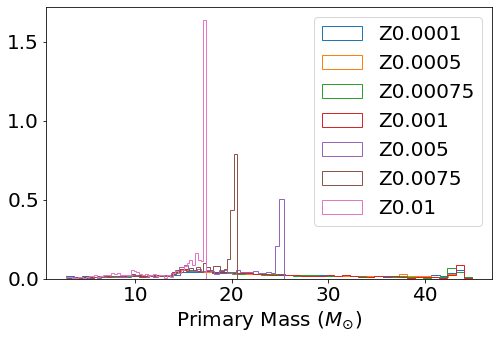

In [5]:
fig, ax = plt.subplots(figsize=(8,5))

for key, item in store.items():
    BBH, SN, BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup = item
    
    ax.hist(BBH['   Mass(1)    '].values, bins=50, histtype='step', density=True, label = key)
    
ax.legend()
ax.set_xlabel('Primary Mass ($M_{\mathrm{\\odot}}$)')

In [12]:
help(functions.ClusterMass)

Help on function ClusterMass in module functions:

ClusterMass(vesc, rh, w0=7)
    Finds the cluster mass given a certain half-mass radii and cluster escape velocity
    from the equation vesc = fcl * (Mcl/1e6)^(1/2) * (rh/1)^(-1/2).
    
    Input >>> vesc = escape velocity [km/s]
              rh = cluster half-mass radius [pc]
              w0 = king cluster concentration parameter (=7 for most my models)
    
    Output >>> Mcl = cluster mass [Msol]



In [31]:
vesc = [10, 50, 100] # escape velocity array

vesc = 50 #km/s
rh = 1 #pc

# Find cluster mass given rh and vesc
Mcl = functions.ClusterMass(vesc, rh)


# Empty retained fraction array
tot_bound = []
tot_unbound = []
total_retained = []

# Make the metallicities into an array
metal = np.array([float(i.split('Z')[-1]) for i in list(store.keys())])

for key, item in store.items():
    BBH, SN, BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup = item
    
    # Reset the counters
    retainedSingle=0
    retainedBound=0
    
    # Those systems that form a BH but the second star never goes SN
    retainedSingle+=len(BHSingUnbound.loc[BHSingUnbound['ComponentSpeed(SN)']<vesc])
    retainedBound+=len(BHSingBound.loc[BHSingBound['ComponentSpeed(SN)']<vesc])

    # seeds retained from first SN
    retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
    retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
    retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]
    
    # BBHbound retained after second
    index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
    BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]
    
    retainedBound+=2*len(BBHRetain)
    
    # BBHUnbound on second
    index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)])
    retainedSingle+=len(BBHUnbound.loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)])
    
    # BHElse on Second
    index = BHElse['    SEED    '].isin(retainedInFirst['    SEED    '])
    retainedBound+=len(BHElse.loc[(index)&(BHElse['SystemicSpeed ']<vesc)&(BHElse['Unbound']==0)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(SN)']<vesc)&(BHElse['Stellar_Type(SN)']==14)&(BHElse['Unbound']==1)])
    retainedSingle+=len(BHElse.loc[(index)&(BHElse['ComponentSpeed(CP)']<vesc)&(BHElse['Stellar_Type(CP)']==14)&(BHElse['Unbound']==1)])
    
    # retainedUnbound on first
    retainedSingle+=len(retainedSN.loc[retainedSN['Stellar_Type(SN)']==14])
    
    index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
    retainedSingle+=len(SN2nd[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)])
    
    # Append to the fractional arrays
    totalretained=retainedSingle+retainedBound
    tot_bound.append(retainedBound)
    tot_unbound.append(retainedSingle)
    total_retained.append(totalretained)
    
tot_bound = np.asarray(tot_bound)
tot_unbound = np.asarray(tot_unbound)
total_retained = np.asarray(total_retained)


Text(0.62, 0.8, '$v_{\\mathrm{esc}}=50$ kms$^{-1}$')

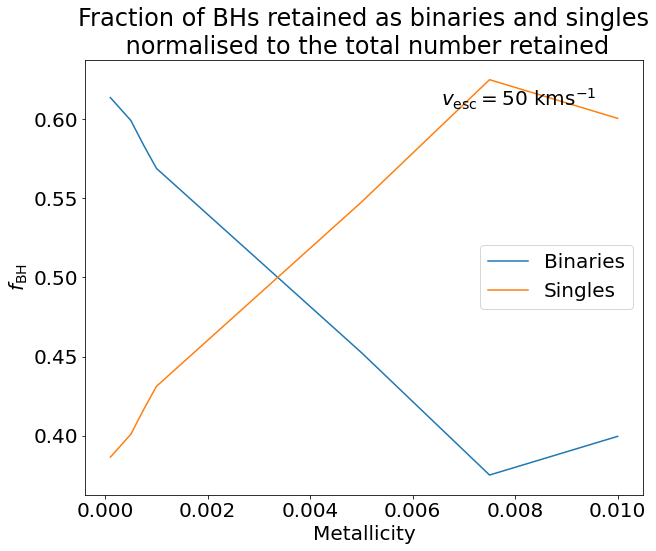

In [32]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(metal, tot_bound/total_retained, label='Binaries')
ax.plot(metal, tot_unbound/total_retained, label='Singles')

ax.legend()
ax.set_xlabel('Metallicity')
ax.set_ylabel('$f_{\mathrm{BH}}$')
ax.set_title('Fraction of BHs retained as binaries and singles\n normalised to the total number retained')
fig.text(0.62, 0.8, f'$v_{{\mathrm{{esc}}}}={vesc}$ kms$^{{-1}}$')


In [33]:
#Perturber mass
m3 = 20 #Msol

# Finding the cluster density
rho = (3*Mcl)/(8*np.pi*rh**3)

# Lists to store the fractions
pop1frac = []
pop2frac = []
pop3frac = []
softfrac = []

#Print cluster properties
print(f'Cluster Mass = {Mcl} Msol')
print(f'Cluster half-mass radii = {rh} pc')
print(f'Cluster density at rh = {rho} Msol/pc^3')
print(f'Cluster escape velocity = {vesc} km/s\n')




for key, item in store.items():
    BBH, SN, BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup = item
    
    # Find sigma
    sigma = vesc/4.77 # For King cluster mode with W0=7
    
    # Calculate relaxation time for cluster
    trh = functions.calcTrh(M=Mcl, rh=rh)
    
    # Classify every BBH initially as pop 0 to be changed later
    BBH['Pop'] = np.zeros(len(BBH))
    
    # Find the BBH's that escape solely from SN kicks
    esc=[]

    for name in BBH['    SEED    ']:
        # Find both SN information
        temp = SN.loc[SN['    SEED    '] == name]

        if (temp['SystemicSpeed '].values<vesc).all():
            esc.append(0)
        elif temp['SystemicSpeed '].values[0]>=vesc:
            esc.append(1)
        elif temp['SystemicSpeed '].values[1]>=vesc:
            esc.append(2)
    
    # Add this as column
    esc = np.asarray(esc)
    BBH['Escaped'] = esc
    
    # Classify as pop1
    BBH['Pop'].loc[(BBH['Escaped']!=0)&(BBH['Merges_Hubble_Time']==1)] = int(1)

    # Find the BBHs that are hard
    # Find the ah cut off for every binary
    mu = (BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    '])
    ah = (G*Rsol2AU)*mu/sigma**2

    # Classify a binary as hard if its a < ah
    hard  = np.zeros(len(BBH))
    hard[np.where(BBH['SemiMajorAxis@DCO']<=ah)] = int(1)

    # Add to the BBH file
    BBH['Hard'] = hard
    
    # Find interaction time for all binaries and add as column
    tint = functions.calcTint(M1=BBH['   Mass(1)    '], M2=BBH['   Mass(2)    '], a=BBH['SemiMajorAxis@DCO'], Mcl=Mcl, rh=rh, trh=trh)
    BBH['Tint']=tint
    
    # Find pop 1 binaries that don't escape but merge before an interaction
    retainedMerge = (BBH['Merges_Hubble_Time']==1)&(BBH['Escaped']==0)&(BBH['Hard']==1)
    mergeBeforeInt = (BBH['Tint']+BBH['      Time      '])>BBH['Coalescence_Time']
    BBH['Pop'].loc[retainedMerge & mergeBeforeInt] = int(1)
    
    # Finding index for all pop1
    pop1 = BBH['Pop']==1
    
    # Finding the ejection semi-major axis and add to the dataframe (assume same perturber mass for all interactions)
    aej = 0.4*(G)/(vesc**2)*(BBH['   Mass(1)    ']*BBH['   Mass(2)    '])/(BBH['   Mass(1)    ']+BBH['   Mass(2)    ']+m3) # Rsol
    aej*=Rsol2AU
    
    # Add as a column
    BBH['aej'] = aej
    
    # In this simple model we define pop 2 as BBHs below the aej value that are not pop 1
    belowAej = (BBH['SemiMajorAxis@DCO']<=BBH['aej'])
    pop2 = (belowAej)&(BBH['Pop']!=1)
    mergingIndex = (BBH['Merges_Hubble_Time']==1)
    BBH['Pop'].loc[pop2] = 2
    
        
    # Pop 3 are BBHs that are hard and so will likely merge at some point but experience more than 1 interaction and are not ejected
    pop3 = ~pop1 & ~pop2 & (BBH['SemiMajorAxis@DCO']>BBH['aej']) & (BBH['Hard']==1)
    BBH['Pop'].loc[pop3] = 3 
    
 
    total = len(BBH)
    
    
    print('Pop 1 frac: {:.3g}'.format(len(BBH.loc[pop1])/total))
    print('Pop 2 frac: {:.3g}'.format(len(BBH.loc[pop2])/total))
    print('Pop 3 frac: {:.3g}\n'.format(len(BBH.loc[pop3])/total))
    
    
    pop1frac.append(len(BBH.loc[pop1])/total)
    pop2frac.append(len(BBH.loc[pop2])/total)

    pop3frac.append(len(BBH.loc[pop3])/total)
    softfrac.append(len(BBH.loc[BBH['Pop']==0])/total)
    

    # Here we ensure that the primary mass is labelled as m1
    primMass = BBH['   Mass(1)    ']<BBH['   Mass(2)    ']
    BBH.loc[primMass, ['   Mass(1)    ', '   Mass(2)    ', 'Stellar_Type(1)', 'Stellar_Type(2)']] = BBH.loc[primMass, [ '   Mass(2)    ', '   Mass(1)    ', 'Stellar_Type(2)', 'Stellar_Type(1)']]    

    print(f'\nFinished {key}\n')

Cluster Mass = 175654.43573120376 Msol
Cluster half-mass radii = 1 pc
Cluster density at rh = 20967.203791979042 Msol/pc^3
Cluster escape velocity = 50 km/s

Pop 1 frac: 0.0837
Pop 2 frac: 0.264
Pop 3 frac: 0.307


Finished Z0.0001

Pop 1 frac: 0.0809
Pop 2 frac: 0.236
Pop 3 frac: 0.28


Finished Z0.0005

Pop 1 frac: 0.074
Pop 2 frac: 0.228
Pop 3 frac: 0.281


Finished Z0.00075

Pop 1 frac: 0.0692
Pop 2 frac: 0.217
Pop 3 frac: 0.278


Finished Z0.001

Pop 1 frac: 0.013
Pop 2 frac: 0.101
Pop 3 frac: 0.309


Finished Z0.005

Pop 1 frac: 0.0152
Pop 2 frac: 0.0431
Pop 3 frac: 0.3


Finished Z0.0075

Pop 1 frac: 0.0238
Pop 2 frac: 0.0355
Pop 3 frac: 0.307


Finished Z0.01



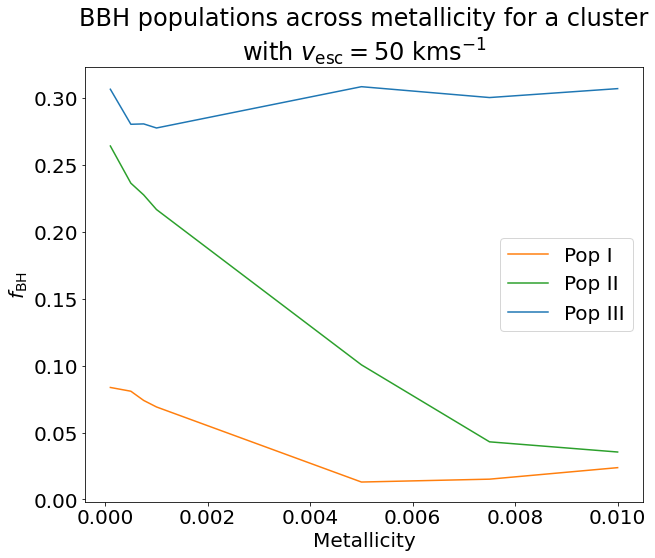

In [34]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(metal, pop1frac, color='tab:orange', label='Pop I ')
ax.plot(metal, pop2frac, color='tab:green', label='Pop II')
ax.plot(metal, pop3frac, color='tab:blue', label='Pop III')

ax.legend()
ax.set_xlabel('Metallicity')
ax.set_ylabel('$f_{\mathrm{BH}}$')
ax.set_title(f'BBH populations across metallicity for a cluster\nwith $v_{{\mathrm{{esc}}}} = {vesc}$ kms$^{{-1}}$');

In [35]:
'''
Splitting the pop2 into those that would merge due to SE (lower limit)
and those that would merge after the averaged affect over 10 interactions

Finding lower estimate on pop 3 merging fraction by assuming they all reach aej
calculate 10 interactions and average over
'''
pop1frac_inside = []
pop1frac_outside = []

pop2frac_SEmerge = []
pop2frac_intmerge = []

pop3frac_intmerge = []

totalLower = []
totalUpper = []

total = []

count = 0
for key, item in store.items():
    BBH, SN, BHSingUnbound, BHSingBound, BBHUnbound, BBHBound, BHElse,  SN1st, SN2nd, SNDup = item
    total.append(len(BBH))
    
    # Find the pop1, pop2 and pop3
    pop1 = (BBH['Pop']==1)
    pop2 = (BBH['Pop']==2)
    pop3 = (BBH['Pop']==3)
    
    # Find those that binaries that are already in a merging regime after SE
    mergingIndex = (BBH['Merges_Hubble_Time']==1)
    
    # Calculating the mergers due to an interaction
    if len(BBH.loc[pop2])>0:
        avgMerge = functions.calcMergeFromInteractions(m1=BBH['   Mass(1)    '].loc[pop2].values, 
                                             m2=BBH['   Mass(2)    '].loc[pop2].values,
                                             semi=BBH['SemiMajorAxis@DCO'].loc[pop2].values/Rsol2AU,
                                             tint=BBH['Tint'].loc[pop2].values+BBH['      Time      '].loc[pop2].values,
                                             N=10)
        
        # Finding the number that merge within a hubble time
        numIntMerge = len(avgMerge[avgMerge<=13.7e3])
    
    else:
        numIntMerge = 0
    
    # Lower limit for mergers is how many would merge once they reach aej
    if len(BBH.loc[pop3])>0:
        # Find roughly how many interactions it takes to reach the aej
        numInt = np.round(np.log10(BBH['SemiMajorAxis@DCO'].loc[pop3].values/BBH['aej'].loc[pop3].values)/np.log10(1.4))
        avgMerge = functions.calcMergeFromInteractions(m1=BBH['   Mass(1)    '].loc[pop3].values,
                                             m2=BBH['   Mass(2)    '].loc[pop3].values,
                                             semi=BBH['aej'].loc[pop3].values/Rsol2AU,
                                             tint=BBH['Tint'].loc[pop3].values*numInt+BBH['      Time      '].loc[pop3].values,
                                             N=10)
        
        numInt3Merge = len(avgMerge[avgMerge<=13.7e3])
        
    else:
        numInt3Merge = 0
        
    
    totalUpper.append(len(BBH.loc[pop1]) + numIntMerge + numInt3Merge)
    totalLower.append(len(BBH.loc[pop1]) + len(BBH.loc[(pop2)&(mergingIndex)]) + numInt3Merge)
    
    
    print('###########################')
    print('Vesc = {:.3g} kms^-1\n'.format(vesc))
    print('Pop 1 mergers (inside): {}'.format(len(BBH.loc[(pop1)&(BBH['Escaped']==0)])))
    print('Pop 1 mergers (outside): {}\n'.format(len(BBH.loc[(pop1)&(BBH['Escaped']>0)])))
    
    print('Pop 2 frac merging from SE: {}'.format(len(BBH.loc[(pop2)&(mergingIndex)])))
    print('Pop 2 frac merging from int: {}\n'.format(numIntMerge))
    
    print('Pop 3 frac merging from interaction once aej reached: {}\n'.format(numInt3Merge))
    

    
    pop1frac_inside.append(len(BBH.loc[(pop1)&(BBH['Escaped']==0)]))
    pop1frac_outside.append(len(BBH.loc[(pop1)&(BBH['Escaped']>0)]))

    pop2frac_SEmerge.append(len(BBH.loc[(pop2)&(mergingIndex)]))
    pop2frac_intmerge.append(numIntMerge)
    
    pop3frac_intmerge.append(numInt3Merge)
    
    count+=1
    
    print(f'Completed {key}')
    
pop1frac_inside = np.asarray(pop1frac_inside)
pop1frac_outside = np.asarray(pop1frac_outside)

pop2frac_SEmerge = np.asarray(pop2frac_SEmerge)
pop2frac_intmerge = np.asarray(pop2frac_intmerge)

pop3frac_intmerge = np.asarray(pop3frac_intmerge)

totalLower = np.asarray(totalLower)
totalUpper = np.asarray(totalUpper)

total = np.asarray(total)


###########################
Vesc = 50 kms^-1

Pop 1 mergers (inside): 90
Pop 1 mergers (outside): 1167

Pop 2 frac merging from SE: 2375
Pop 2 frac merging from int: 3090

Pop 3 frac merging from interaction once aej reached: 94

Completed Z0.0001
###########################
Vesc = 50 kms^-1

Pop 1 mergers (inside): 4
Pop 1 mergers (outside): 1034

Pop 2 frac merging from SE: 1059
Pop 2 frac merging from int: 2005

Pop 3 frac merging from interaction once aej reached: 109

Completed Z0.0005
###########################
Vesc = 50 kms^-1

Pop 1 mergers (inside): 1
Pop 1 mergers (outside): 872

Pop 2 frac merging from SE: 790
Pop 2 frac merging from int: 1739

Pop 3 frac merging from interaction once aej reached: 117

Completed Z0.00075
###########################
Vesc = 50 kms^-1

Pop 1 mergers (inside): 4
Pop 1 mergers (outside): 756

Pop 2 frac merging from SE: 586
Pop 2 frac merging from int: 1536

Pop 3 frac merging from interaction once aej reached: 119

Completed Z0.001
############

Text(0, 0.5, '$f_{\\mathrm{BH}}(Merge)$')

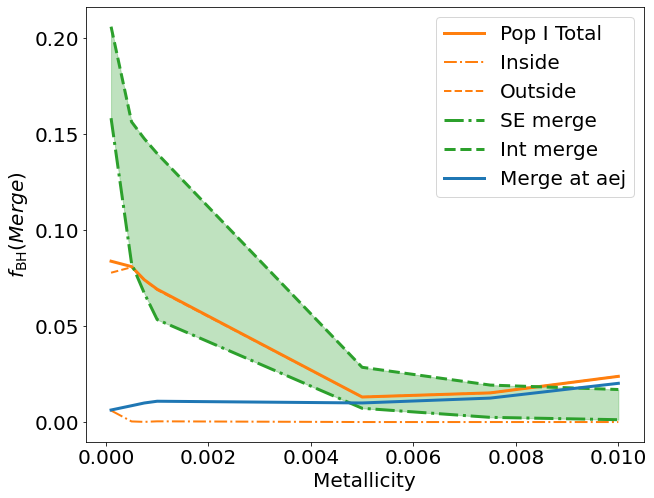

In [36]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(metal, (pop1frac_inside+pop1frac_outside)/total, color='tab:orange', linewidth=3, label='Pop I Total')

ax.plot(metal, pop1frac_inside/total, color='tab:orange', label='Inside', linewidth=2, linestyle='-.')
ax.plot(metal, pop1frac_outside/total, color='tab:orange', label='Outside', linewidth=2, linestyle='--')


ax.plot(metal, pop2frac_SEmerge/total, color='tab:green', linewidth=3, label='SE merge', linestyle='-.')
ax.plot(metal, pop2frac_intmerge/total, color='tab:green', linewidth=3, label='Int merge', linestyle='--')
ax.fill_between(metal, pop2frac_SEmerge/total, pop2frac_intmerge/total, alpha=0.3, color='tab:green')


ax.plot(metal, pop3frac_intmerge/total, color='tab:blue', linewidth=3, label='Merge at aej')

ax.legend()
ax.set_xlabel('Metallicity')
ax.set_ylabel('$f_{\mathrm{BH}}(Merge)$')